# OptiML Project - Text classification models optimization

## Imports

In [23]:
!pip install datasets

In [24]:
import random
from collections import namedtuple, Counter
from functools import partial
import gc
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm, trange
# from tqdm import tqdm, trange
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoConfig

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Using GPU')
else:
    raise Exception('Using CPU')

Using GPU


## Setup the seed
For reproducibility purposes, we will set the seed of the random number generators

In [26]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)


seed = 42
seed_everything(seed)

## Load the data

In [27]:
dataset = load_dataset('cwchang/text-classification-dataset-example')
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 7500
    })
})

In [28]:
pd.DataFrame(dataset['train'])

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


### Dataset exploration

In [29]:
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 15000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 3000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 7500
 }))

In [30]:
pd.DataFrame(train_dataset)

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


In [31]:
pd.DataFrame(val_dataset)

,label,text,id
0,cook_time,how long should i cook steak for,eval-0
1,balance,please tell me how much money i have in my ban...,eval-1
2,gas,what is the gas level in my gas tank,eval-2
3,time,how late is it now in ourense,eval-3
4,car_rental,i really need to get a volkswagen car rental f...,eval-4
...,...,...,...
2995,current_location,please tell me the address of my current location,eval-2995
2996,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
2997,change_volume,please turn your volume up,eval-2997
2998,improve_credit_score,show me a plan to help my credit score rating,eval-2998


In [32]:
pd.DataFrame(test_dataset)

,label,text,id
0,bill_balance,how much are my rent and cable,test-0
1,restaurant_suggestion,i need some suggestions for dinner places tonight,test-1
2,report_lost_card,can you report a lost card for me,test-2
3,timezone,timezone currently in mobile,test-3
4,what_is_your_name,tell me what to call you,test-4
...,...,...,...
7495,current_location,please tell me the address of my current location,eval-2995
7496,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
7497,change_volume,please turn your volume up,eval-2997
7498,improve_credit_score,show me a plan to help my credit score rating,eval-2998


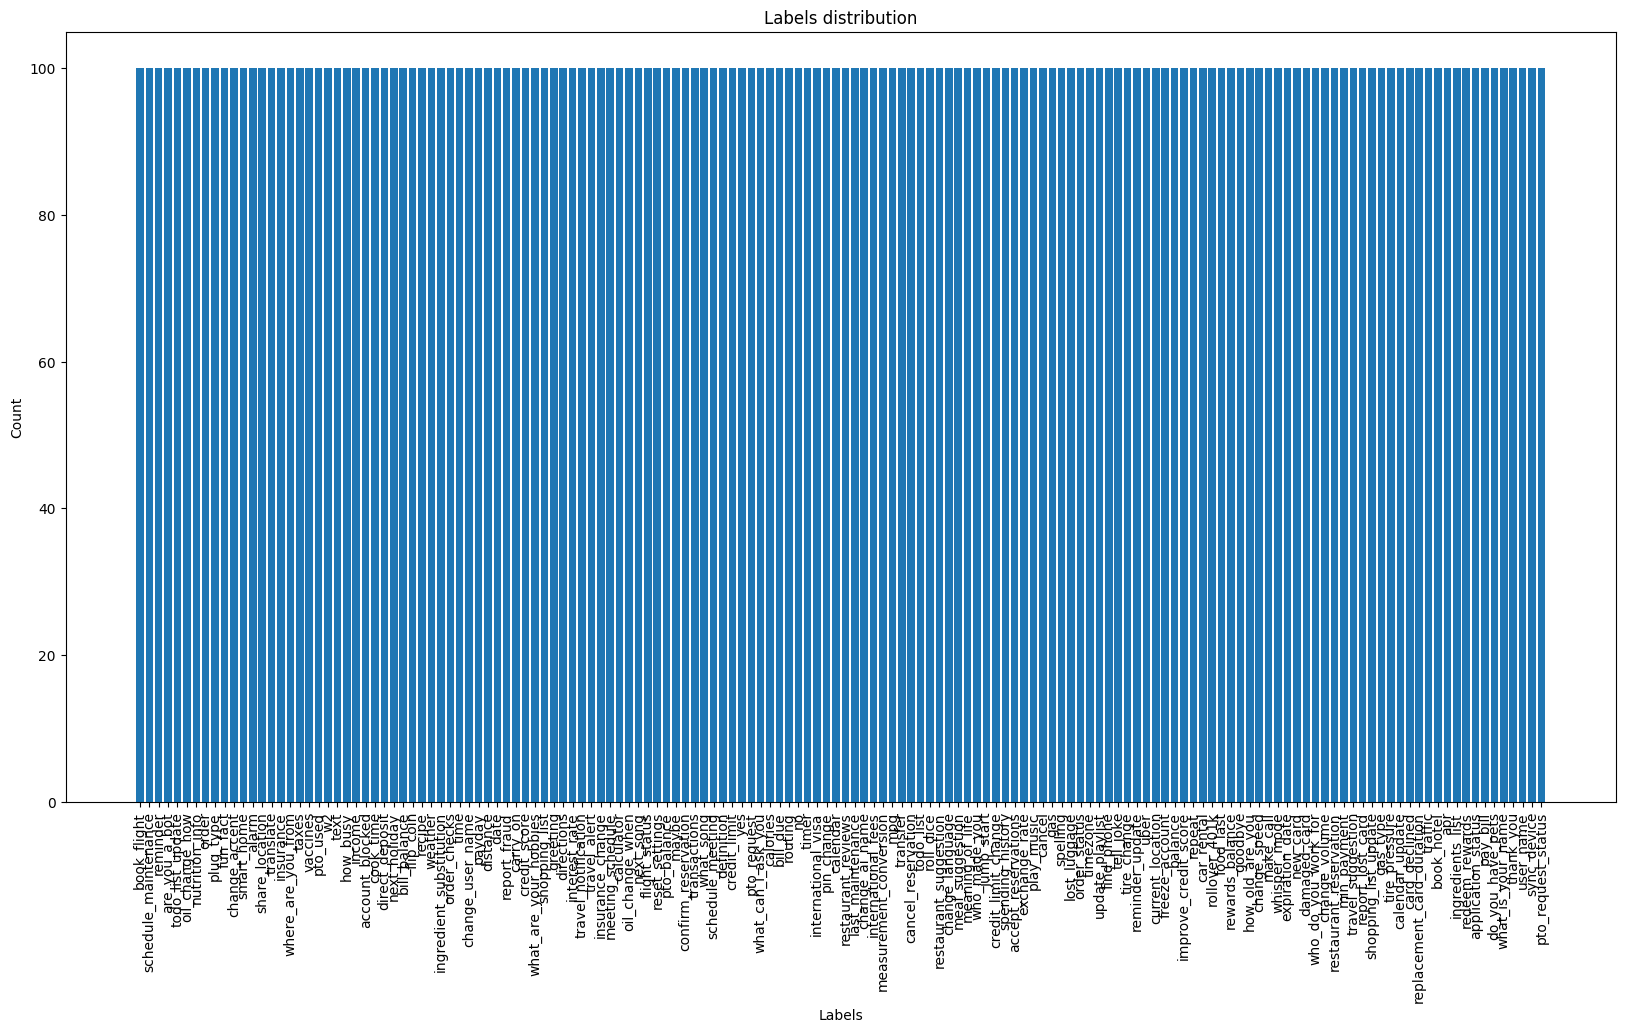

In [33]:
labels_counter = Counter([d['label'] for d in train_dataset])
plt.figure(figsize=(20, 10))
plt.bar(labels_counter.keys(), labels_counter.values())
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Labels distribution')
plt.show()

In [34]:
# Extract the unique labels from the 'label' column of the train_dataset
classes = list(set(train_dataset['label']))
# Create a dictionary to map each label to a unique integer ID
label2id = {c: i for i, c in enumerate(classes)}
# Create a dictionary to map each unique integer ID back to the corresponding label
id2label = {i: c for c, i in label2id.items()}
num_labels = len(classes)
# Create a DataFrame to display the classes and their corresponding indices
pd.DataFrame({'class': list(classes), 'idx': list(label2id.values())})

,class,idx
0,mpg,0
1,gas,1
2,insurance_change,2
3,transactions,3
4,sync_device,4
...,...,...
145,rollover_401k,145
146,improve_credit_score,146
147,shopping_list_update,147
148,book_flight,148


In [35]:
num_labels

150

## Load pretrained tokenizer (RoBERTa)

In [36]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
# model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Prepare dataloaders

In [37]:
def prepare_dataset(dataset):
    # Extract the 'text' field from each element in the dataset
    texts = [d['text'] for d in dataset]
    # Tokenize the texts, padding them to the same length and truncating if necessary
    # The `.to(device)` method moves the tensors to the specified device (e.g., GPU or CPU)
    tokenized = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
    print("Fields of the tokenized output:", tokenized.keys())
    # print("Tokenized output:", tokenized)
    # Convert the labels to their corresponding IDs using the label2id dictionary
    labels_ids = [label2id[d['label']] for d in dataset]
    # Convert the label IDs to a PyTorch tensor and move it to the specified device
    labels = torch.tensor(labels_ids).to(device)
    # Create a TensorDataset with the tokenized input IDs, attention masks, and labels
    # The TensorDataset will be used for loading the data in batches during training or evaluation
    return TensorDataset(tokenized['input_ids'], tokenized['attention_mask'], labels)

In [38]:
train_tokenized = prepare_dataset(train_dataset)
train_dataloader = DataLoader(train_tokenized, batch_size=128, shuffle=True)

Fields of the tokenized output: dict_keys(['input_ids', 'attention_mask'])


In [39]:
val_tokenized = prepare_dataset(val_dataset)
val_dataloader = DataLoader(val_tokenized, batch_size=128, shuffle=False)

Fields of the tokenized output: dict_keys(['input_ids', 'attention_mask'])


In [40]:
test_tokenized = prepare_dataset(test_dataset)
test_dataloader = DataLoader(test_tokenized, batch_size=128, shuffle=False)

Fields of the tokenized output: dict_keys(['input_ids', 'attention_mask'])


## Training and evaluation functions

### Training

In [41]:
def lr_lambda(current_epoch, num_epochs, warmup_epochs):
    """
    Calculate the learning rate multiplier for the current epoch.

    Parameters:
    - current_epoch (int): The current epoch number during training.
    - num_epochs (int): The total number of epochs for training.
    - warmup_epochs (int): The number of epochs to linearly increase the learning rate.

    Returns:
    - float: The multiplier for the learning rate.

    If the current epoch is within the warmup period, the learning rate increases linearly.
    After the warmup period, the learning rate follows a cosine annealing schedule.
    """
    if current_epoch < warmup_epochs:
        # Linearly increase the learning rate during the warmup period
        return current_epoch / warmup_epochs
    else:
        # Apply cosine annealing after the warmup period
        return 0.5 * (1 + math.cos(math.pi * (current_epoch - warmup_epochs) / (num_epochs - warmup_epochs)))


In [55]:
import math
from collections import namedtuple

def train (model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          scheduler: str,
          optimizer: optim.Optimizer,
          num_epochs: int,
          warmup_epochs: int = 2):
    # Set a seed for reproducibility
    seed_everything(seed)
    if scheduler is None:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)
    elif scheduler == "dynamic":
      # Define the learning rate lambda function
      lr_lambda_func = lambda epoch: lr_lambda(epoch, num_epochs, warmup_epochs)
      # Create the LambdaLR scheduler
      scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda_func)

    # Create a progress bar for the training process
    t = trange(num_epochs, desc='Training', leave=True)

    # Initialize lists to store training and validation losses and accuracies
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Loop over each epoch
    for epoch in t:
        train_loss = 0  # Initialize training loss for the epoch
        train_acc = 0   # Initialize training accuracy for the epoch

        # Zero the gradients for the model and optimizer
        model.zero_grad()
        optimizer.zero_grad()

        # Set the model to training mode
        model.train()

        # Loop over each batch in the training dataloader
        for X_batch, attention_mask, y_batch in tqdm(train_dataloader, leave=False, desc='Epoch', position=0):
            model.zero_grad()  # Zero the gradients for the model
            optimizer.zero_grad()  # Zero the gradients for the optimizer

            # Forward pass: compute the model's output given the inputs and attention masks
            outputs = model(X_batch, attention_mask=attention_mask, labels=y_batch)

            # Extract the loss from the model's output
            loss = outputs.loss

            # Backward pass: compute the gradient of the loss with respect to model parameters
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate the loss and accuracy for the current batch
            train_loss += loss.item()
            train_acc += (torch.argmax(outputs.logits, 1) == y_batch).sum().item() / y_batch.size(0)

        # Calculate average training loss and accuracy for the epoch
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        # Set the model to evaluation mode
        model.eval()

        # Evaluate the model on the validation dataset
        acc, val_loss, _ = evaluate(model, val_dataloader)

        # Step the learning rate scheduler
        scheduler.step()

        # Append the training and validation metrics to their respective lists
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(acc)

        # Update the progress bar with the current metrics
        t.set_postfix(train_loss=train_loss, val_loss=val_loss, acc=acc)

    # Return the training and validation metrics as a namedtuple
    return namedtuple('Training', ['train_losses', 'val_losses', 'train_accs', 'val_accs'])(train_losses, val_losses, train_accs, val_accs)


### Evaluation

In [43]:
# Function to evaluate a model on a test dataset
def evaluate(model: nn.Module,
             test_dataloader: torch.utils.data.DataLoader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize a confusion matrix of size (num_labels x num_labels) filled with zeros
    confusion_matrix = np.zeros((num_labels, num_labels))

    # Initialize variables to accumulate test loss, correct predictions, and total samples
    test_loss = 0
    correct = 0
    total = 0

    # Disable gradient calculation for evaluation (saves memory and computation)
    with torch.no_grad():
        # Loop over each batch in the test dataloader
        for X_batch, attention_mask, y_batch in tqdm(test_dataloader, leave=False, desc='Evaluation', position=0):
            # Forward pass: compute the model's output given the inputs and attention masks
            outputs = model(X_batch, attention_mask=attention_mask, labels=y_batch)

            # Extract the loss from the model's output
            loss = outputs.loss

            # Accumulate the test loss for the current batch
            test_loss += loss.item()

            # Get the predicted labels by taking the class with the highest logit score
            _, predicted = torch.max(outputs.logits, 1)

            # Update the total number of samples processed
            total += y_batch.size(0)

            # Update the number of correct predictions
            correct += (predicted == y_batch).sum().item()

            # Update the confusion matrix by incrementing the counts for each true-predicted pair
            for t, p in zip(y_batch.view(-1), predicted.view(-1)):
                confusion_matrix[p.long(), t.long()] += 1

    # Calculate the overall accuracy as the ratio of correct predictions to total samples
    acc = correct / total

    # Calculate the average test loss over all batches
    test_loss /= len(test_dataloader)

    # Return the evaluation metrics as a namedtuple
    return namedtuple('Evaluation', ['accuracy', 'loss', 'confusion_matrix'])(acc, test_loss, confusion_matrix)


## Plotting Functions for Training and Evaluation

In [44]:
def plot_training(training):
    """
    Plot a single graph with training and validation losses on the left axis and validation accuracy on the right axis.
    :param training: namedtuple('Training', ['train_losses', 'val_losses', 'accs'])
    :return: None
    """
    epochs = range(1, len(training.train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses on left axis
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, training.train_losses, color=color, label='Train Loss')
    ax1.plot(epochs, training.val_losses, color='tab:cyan', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y-axis for validation accuracy on right axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, training.train_accs, color=color, linestyle='--', label='Train Accuracy')
    ax2.plot(epochs, training.val_accs, color='tab:orange', linestyle='--', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Set title and legend
    plt.title('Training and Validation Metrics')
    fig.tight_layout()
    fig.legend(loc='upper right')

    # Show plot
    plt.show()



In [45]:

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(30, 30))
    plt.imshow(confusion_matrix, cmap='Reds', interpolation='nearest')
    plt.xticks(np.arange(num_labels), classes, rotation=90)
    plt.yticks(np.arange(num_labels), classes)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

## Hyperparameters

In [46]:
@dataclass
class TrainingConfig:
    optimizer: '(params, lr, weight_decay) -> Optimizer'
    num_epochs: int
    learning_rate: float
    weight_decay: float

In [47]:
num_epochs = 10
weight_decay = 1e-2

In [51]:
configs = {
    'SGD': TrainingConfig(optimizer=torch.optim.SGD,
                          num_epochs=num_epochs,
                          learning_rate=5e-2,
                          weight_decay=weight_decay),

    'SGD with momentum': TrainingConfig(optimizer=partial(torch.optim.SGD, momentum=0.9),
                                        num_epochs=num_epochs,
                                        learning_rate=5e-3,
                                        weight_decay=weight_decay),

    'Adam': TrainingConfig(optimizer=torch.optim.Adam,
                           num_epochs=num_epochs,
                           learning_rate=5e-5,
                           weight_decay=weight_decay),

    'AdamW': TrainingConfig(optimizer=torch.optim.AdamW,
                            num_epochs=num_epochs, learning_rate=5e-5,
                            weight_decay=weight_decay),


    'RMSprop' :  TrainingConfig(optimizer=torch.optim.RMSprop,
                            num_epochs=num_epochs, learning_rate=5e-5,
                            weight_decay=weight_decay),
}

## Fine-tuning the model
In this section we will try to fine tune the model using different optimizers to compare their performance against each other when fine-tuning transformers.

In [56]:
for opt_name, config in configs.items():
    # set seed for reproducibility
    seed_everything(seed)

    # reload the original model
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

    optimizer = config.optimizer(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    print(f'Optimizer: {opt_name}', 'Learning rate:', config.learning_rate, 'Weight decay:', config.weight_decay, 'Num epochs:', config.num_epochs)

    training = train(model=model,
                     train_dataloader=train_dataloader,
                     val_dataloader=val_dataloader,
                     optimizer=optimizer,
                     scheduler="dynamic",
                     num_epochs=config.num_epochs,
                     warmup_epochs= 2)

    evaluation = evaluate(model, test_dataloader)

    print(f'Validation accuracy: {evaluation.accuracy}')
    print(f'Validation loss: {evaluation.loss}')

    plot_training(training)
    plot_confusion_matrix(evaluation.confusion_matrix)

    # save the model
    torch.save(model.state_dict(), f'roberta_{opt_name}.pt')

    # release the memory
    del model
    del optimizer
    del training
    del evaluation
    gc.collect()
    torch.cuda.empty_cache()

    print('#' * 50)

Output hidden; open in https://colab.research.google.com to view.